# Adversarial Attacks

In this file, we will be looking at using adversarial attacks to confuse a neural network.

Specifically I will be using the MNIST Dataset which is a dataset of handwritten digits (0-9).

I recommend using Google Colab to run this file (especially if you don't have a GPU), or else it may take a long time to run (or may not run at all).

You'll find untargetted and targetted adversarial attacks in this notebook.

In [ ]:
# Standard imports
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# In case you are fortunate enough to have access to a GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset: flattened MNIST

In [ ]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [ ]:
def draw(x):
    '''Displays a flattened MNIST digit'''
    with torch.no_grad():
        plt.imshow(x.cpu().numpy().reshape((img_size,img_size)), cmap='gray');
        plt.axis('off');

In [ ]:
x,t = ds.__getitem__(5000)
draw(x)

# Network
Creating a Network to be able to perform classification on the MNIST Dataset.

In [ ]:
class MyNet(nn.Module):
    '''
     net = MyNet(img_size=28)

     Creates a neural network to do classification on MNIST.
     It assumes the images will be (img_size)x(img_size).

     The output of the network is the log of the 10 class probabilities
     (ie. log-softmax). Correspondingly, this network uses the
     negative log-likelihood loss function (nn.NLLLoss).
    '''
    def __init__(self, img_size=28):
        super().__init__()
        self.lyrs = nn.Sequential(
            nn.Linear(img_size**2, 100), nn.ReLU(),
            nn.Linear(100, 50), nn.ReLU(),
            nn.Linear(50, 10), nn.LogSoftmax(dim=-1),
            )
        self.loss_fcn = nn.NLLLoss()
        self.losses = []
        self.to(device)


    def forward(self, x):
        return self.lyrs(x)


    def learn(self, dl, optimizer=None, epochs=10):
        '''
         net.learn(dl, optimizer=None, epochs=10)

         Train the network on the dataset represented by the DataLoader dl.
         The default optimizer is Adam().

         The targets for the dataset are assumed to be class indices.
        '''
        if optimizer is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                x = x.to(device)   # for use with a GPU
                t = t.to(device)
                y = self(x)
                loss = self.loss_fcn(y, t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.detach().numpy()
                count += 1.
            self.losses.append(total_loss/len(dl))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
        plt.figure(figsize=(4,4))
        plt.plot(self.losses); plt.yscale('log');

In [ ]:
net = MyNet(img_size)

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)
net.learn(dl, optimizer=torch.optim.Adam(net.parameters(), lr=0.001), epochs=200)

In [ ]:
def accuracy(net, dl):
    total_correct = 0.
    for x,t in dl:
        y = net(x.to(device))
        blah = torch.argmax(y.cpu(), dim=1)
        total_correct += torch.sum(blah==t).cpu().item()
    return total_correct/len(dl.dataset)

dl = torch.utils.data.DataLoader(ds, batch_size=256)
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

# Classify a random digit
idx = np.random.randint(len(ds))
print(idx)
x, t = ds.__getitem__(idx)
y = net(x)
draw(x)
plt.title(f'Predicted: {torch.argmax(y)}, True: {t}');

# `fgsm` Method

In [ ]:
def fgsm(net, x, t, eps=0.01, targ=False):
    '''
        x_adv = FGSM(net, x, t, eps=0.01, targ=False)

        Performs the Fast Gradient Sign Method, perturbing each input by
        eps (in infinity norm) in an attempt to have it misclassified.

        Inputs:
          net    PyTorch Module object
          x      (D,I) tensor containing a batch of D inputs
          t      tensor of D corresponding class indices
          eps    the maximum infinity-norm perturbation from the input
          targ   Boolean, indicating if the FGSM is targetted
                   - if targ is False, then t is considered to be the true
                     class of the input, and FGSM will work to increase the cost
                     for that target
                   - if targ is True, then t is considered to be the target
                     class for the perturbation, and FGSM will work to decrease the
                     cost of the output for that target class

        Output:
          x_adv  tensor of a batch of adversarial inputs, the same size as x
    '''

    # You probably want to create a copy of x so you can work with it.
    x_adv = x.clone().to(device)
    
    for i in range(x_adv.size()[0]):
      input = x[i]
      input.requires_grad = True
      target = t[i]
      y = net(input)
      loss = net.loss_fcn(y, target)
      net.zero_grad()
      loss.backward()
      gradient = input.grad.data.sign()
      if targ == False: # Untargetted
        x_adv[i] = x[i] + eps*gradient
      else: # Targ == True, Targetted
        x_adv[i] = x[i] - eps*gradient
      x_adv[i] = torch.clamp(x_adv[i], 0, 1)
    return x_adv

# Untargetted Adversarial Attack

In [ ]:
# Create a batch consisting of one correctly-classified digit
# from each class.
x_0, t_0 = ds.__getitem__(10)
x_1, t_1 = ds.__getitem__(1986)
x_2, t_2 = ds.__getitem__(4274)
x_3, t_3 = ds.__getitem__(982)
x_4, t_4 = ds.__getitem__(6872)
x_5, t_5 = ds.__getitem__(207)
x_6, t_6 = ds.__getitem__(6229)
x_7, t_7 = ds.__getitem__(9586)
x_8, t_8 = ds.__getitem__(3204)
x_9, t_9 = ds.__getitem__(5523)
x = torch.zeros((10, img_size**2)) 
x[0] = x_0
x[1] = x_1
x[2] = x_2
x[3] = x_3
x[4] = x_4
x[5] = x_5
x[6] = x_6
x[7] = x_7
x[8] = x_8
x[9] = x_9
t = torch.arange(start=0, end=10)

In [ ]:
# Call fgsm on that batch
value = fgsm(net, x, t, eps=0.07)

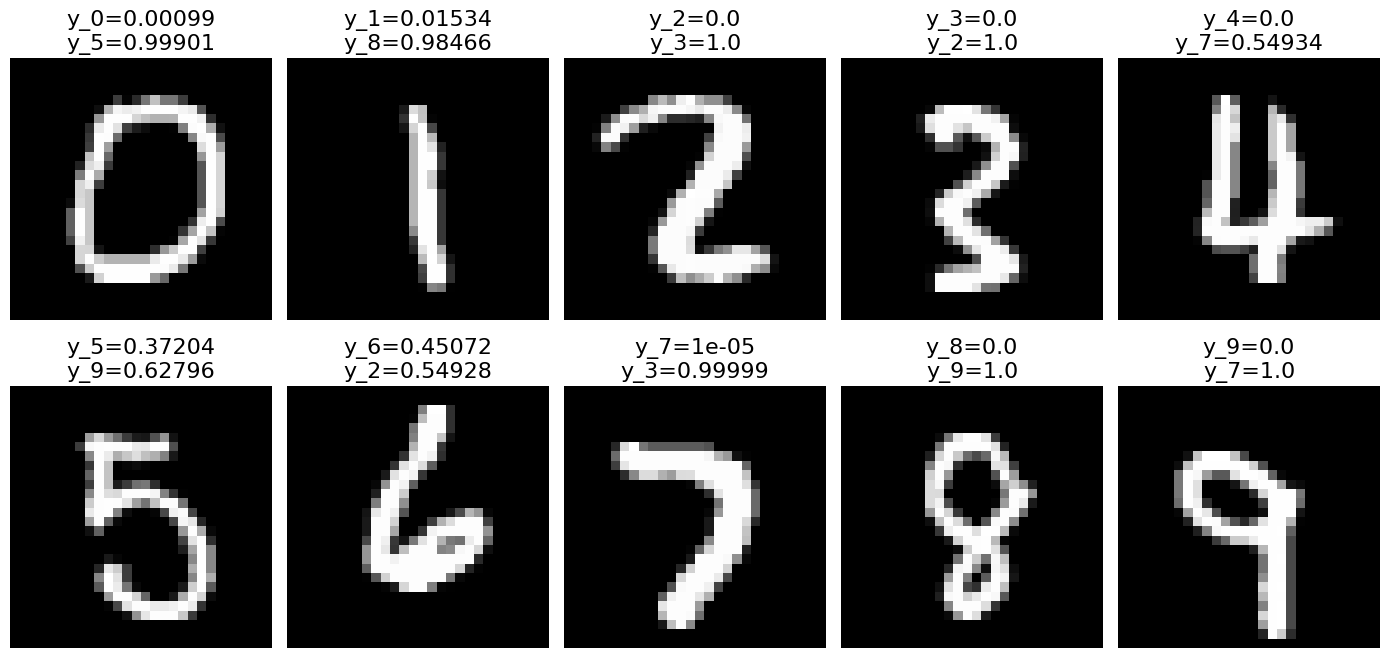

In [ ]:
# Display all 10 digits, including the true class/probability,
# and the predicted class/probability.
plt.figure(figsize=(14,7))
for n,xx in enumerate(x):
    plt.subplot(2,5,n+1); draw(xx);
    # Get the probability of true class
    # original class
    target = t[n].item()
    y = net(value[n])
    probs = torch.exp(y)
    prob_target = probs[target].item()
    # Predicted Class
    max_prob = max(probs).item()
    max_target = 0 # will change
    # Determine which class that max prob belongs to
    for i in range(10):
      if probs[i] == max_prob:
        max_target = i

    title_string = "y_" + str(target) + "=" + str(round(prob_target, 5)) + "\n"
    title_string += "y_" + str(max_target) + "=" + str(round(max_prob, 5))
    plt.title(title_string, fontsize=16)
plt.tight_layout()

# Targetted Adversarial Attack

In [ ]:
# Targetted Adversarial Attack
x_3c, t_3c = ds.__getitem__(1913)
x_8c, t_8c = ds.__getitem__(4890)
x_7c, t_7c = ds.__getitem__(41)
xc = torch.zeros((3, img_size**2))
xc[0] = x_3c
xc[1] = x_8c
xc[2] = x_7c
tc = torch.tensor([8, 6, 3])
targetted_vals = fgsm(net, xc, tc, eps=0.04, targ=True)

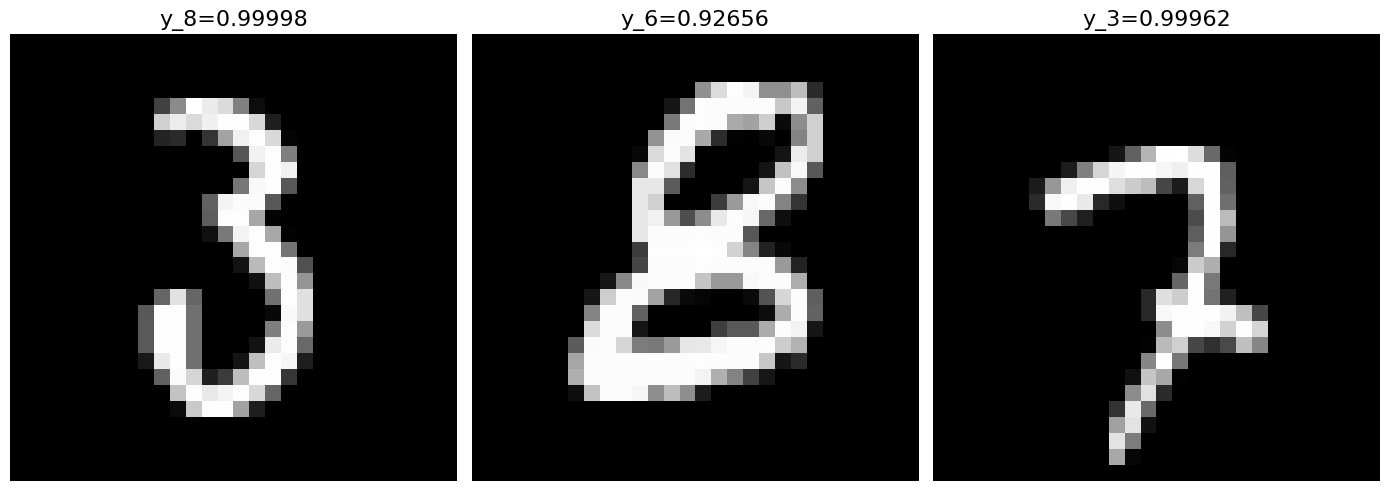

In [ ]:
plt.figure(figsize=(14,7))
for n,xx in enumerate(xc):
    plt.subplot(1,3,n+1); draw(xx);
    # Get the probability of true class
    # original class
    target = tc[n].item()
    y = net(targetted_vals[n])
    probs = torch.exp(y)
    prob_target = probs[target].item()
    title_string = "y_" + str(target) + "=" + str(round(prob_target, 5))
    plt.title(title_string, fontsize=16)
plt.tight_layout()